# Plot the seasonal mean of the variable _snowfall_

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from glob import glob

### Create dask cluster to work parallel in large datasets

from dask.distributed import Client
client = Client(n_workers=2, 
                threads_per_worker=2, 
                memory_limit='4GB',
                processes=False)
client
chunks={'time' : 10,}
client

Client Scheduler: inproc://10.0.0.55/362596/1 Dashboard: http://10.0.0.55:8787/status,Cluster Workers: 2 Cores: 4 Memory: 8.00 GB


In [8]:
_path = '/home/franzihe/nird_NS9600K/franzihe/data/ERA5/3_hourly/'
_path = '/home/franzihe/astra_franzihe/Data/ERA5/1deg/'
var = 'sf'
#var = 'tp'

In [15]:
xr.open_dataset('/home/franzihe/astra_franzihe/Data/ERA5/1deg/sf_Amon_ERA5_1deg_199001_199012.nc').time

<xarray.DataArray 'time' (time: 12)>
array(['1990-01-01T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-03-01T00:00:00.000000000', '1990-04-01T00:00:00.000000000',
       '1990-05-01T00:00:00.000000000', '1990-06-01T00:00:00.000000000',
       '1990-07-01T00:00:00.000000000', '1990-08-01T00:00:00.000000000',
       '1990-09-01T00:00:00.000000000', '1990-10-01T00:00:00.000000000',
       '1990-11-01T00:00:00.000000000', '1990-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 1990-12-01
Attributes:
    long_name:  time

In [11]:
fn_list = [ff for ff in glob(_path + var + '_3hourly_*.nc') if (int(ff[-9:-5])>= 2008)]
fn_list.sort()

if len(fn_list) > 0:

    fn = xr.open_mfdataset(fn_list, chunks = chunks, 
                           parallel = True, 
                           use_cftime = False,
                          ) 
#    fn['time'] = fn.indexes['time'].to_datetimeindex()

In [13]:
_path + var 

'/home/franzihe/astra_franzihe/Data/ERA5/1deg/sf'

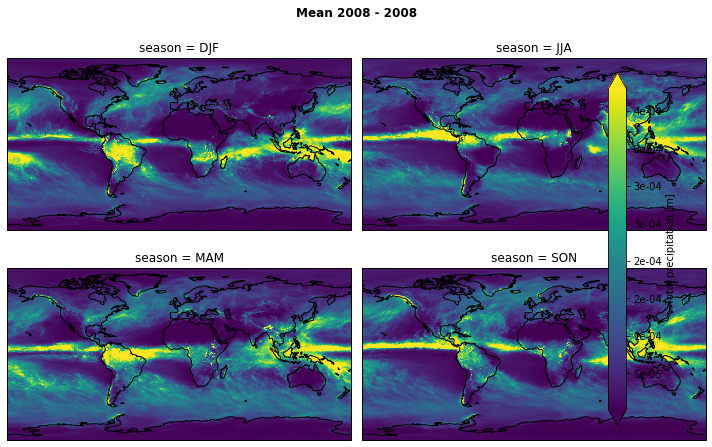

In [4]:
f,axsm = plt.subplots(2,2, figsize = [10,7], subplot_kw={'projection' : ccrs.PlateCarree()})
axs = axsm.flatten()
for sea, ax in zip(fn.tp.groupby('time.season').sum('time').season, axs.flatten()):
    im = fn.tp.sel(time = (fn.tp['time.season'] == sea),).mean('time', keep_attrs = True).plot.pcolormesh(ax = ax,
                                                                                                          transform = ccrs.PlateCarree(),
                                                                                                          robust = True,
                                                                                                          add_colorbar = False)
    ax.coastlines()
f.subplots_adjust(right = 0.8, top = 1.0)
f.suptitle('Mean {starty} - {endy}'.format(starty = np.asarray(fn['time.year'][0]),  endy = np.asarray(fn['time.year'][-1])), fontweight = 'bold')
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(im, 
               cax=cbar_ax, 
               extend = 'both',
               format='%.0e').ax.set_ylabel(fn.tp.attrs['long_name'] + ' [' + fn.tp.attrs['units'] + ']')
plt.tight_layout()